## Machine Learning - Desafío 6, Inferencia de tópicos con EM
#### Gustavo Morales, G10 - 22.Ene.2020, (Miércoles Semana 3)

### **Ejercicio 1: Preparar el ambiente de trabajo**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns
import glob
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
plt.style.use('seaborn-paper')

In [2]:
for name in glob.glob(os.getcwd()+'/dump_plus_pop'):
    print(name)

/home/gus/learn/courses/dlatam_ds/desafios/m3_w03/dump_plus_pop


In [3]:
route = glob.glob('dump_plus_pop/*.csv')
dfs = [pd.read_csv(fname, header=0) for fname in route]
df = pd.concat(dfs, axis=0, ignore_index=True, sort=True)
df.drop(columns='Unnamed: 0', inplace=True)
df.rename(columns={'0': 'artist', '1': 'genre', '2': 'song', '3': 'lyrics'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10804 entries, 0 to 10803
Data columns (total 4 columns):
artist    10804 non-null object
genre     10804 non-null object
song      10804 non-null object
lyrics    10804 non-null object
dtypes: object(4)
memory usage: 337.8+ KB


In [4]:
df.sample(5)

,artist,genre,song,lyrics
6060,Nicki Minaj,pop,Entertainment 2.0,"Yessir! (Ey girl) \n I'mma hit the club, hit t..."
655,De La Soul,hiphop,My Writes,{*Ad libs for the first 30 seconds*} \n (Dove)...
4744,The Doors,rock,We Could Be So Good Together,"Unfortunately, we are not licensed to display ..."
9281,Michael Jackson,pop,Shout,Shout \n Ignorance of people purchasing diamon...
3283,Bruce Springsteen,rock,Jersey Girl,I got no time for the corner boys \n Down in t...


### **Ejercicio 2: Matriz de ocurrencias**

In [5]:
def get_top_n_words(dataframe, n, genre=None):
    df_ = dataframe
    if genre!=None:
        df_ = dataframe[dataframe['genre']==genre]
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer_fit = count_vectorizer.fit_transform(df_['lyrics'])
    words = count_vectorizer.get_feature_names()
    words_freq = count_vectorizer_fit.toarray().sum(axis=0)
    df__ = pd.DataFrame({'words':words, 'frequency':words_freq})
    print(genre) if genre!=None else print('')
    res = df__.sort_values('frequency', ascending=False).head(n)
    return res

In [6]:
get_top_n_words(df, 5000)

,words,frequency
26039,like,22309
13425,don,21310
24895,know,18996
19259,got,17039
24300,just,16993
...,...,...
32899,penance,34
10447,crave,34
35316,puffin,34
34230,population,34


### **Ejercicio 3: Entrenamiento del Modelo**

In [7]:
X = df['lyrics']
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [8]:
pipeline = Pipeline([
    ('cvect', CountVectorizer(stop_words='english')),
    ('latda', LatentDirichletAllocation(
        max_iter=10,
        random_state=42,
        learning_method='online',
        batch_size=128,
        evaluate_every=-1,
        n_jobs=-1))
])

In [9]:
pipeline.get_params().keys()  # displays exact keyworded parameters to pass as input to `grid_param`

dict_keys(['memory', 'steps', 'verbose', 'cvect', 'latda', 'cvect__analyzer', 'cvect__binary', 'cvect__decode_error', 'cvect__dtype', 'cvect__encoding', 'cvect__input', 'cvect__lowercase', 'cvect__max_df', 'cvect__max_features', 'cvect__min_df', 'cvect__ngram_range', 'cvect__preprocessor', 'cvect__stop_words', 'cvect__strip_accents', 'cvect__token_pattern', 'cvect__tokenizer', 'cvect__vocabulary', 'latda__batch_size', 'latda__doc_topic_prior', 'latda__evaluate_every', 'latda__learning_decay', 'latda__learning_method', 'latda__learning_offset', 'latda__max_doc_update_iter', 'latda__max_iter', 'latda__mean_change_tol', 'latda__n_components', 'latda__n_jobs', 'latda__perp_tol', 'latda__random_state', 'latda__topic_word_prior', 'latda__total_samples', 'latda__verbose'])

In [10]:
CV = 3
VERBOSITY = 20
PARAM_GRID = {
    'latda__n_components': [5, 10, 15],
    'latda__learning_decay': [0.7, 0.5]
}

In [11]:
grid_search = GridSearchCV(pipeline, param_grid=PARAM_GRID, cv=CV, return_train_score=True, verbose=VERBOSITY)

In [12]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] latda__learning_decay=0.7, latda__n_components=5 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  latda__learning_decay=0.7, latda__n_components=5, score=(train=-5802471.693, test=-2900423.075), total=  27.0s
[CV] latda__learning_decay=0.7, latda__n_components=5 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.0s remaining:    0.0s


[CV]  latda__learning_decay=0.7, latda__n_components=5, score=(train=-5826501.492, test=-2866597.595), total=  26.0s
[CV] latda__learning_decay=0.7, latda__n_components=5 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.0s remaining:    0.0s


[CV]  latda__learning_decay=0.7, latda__n_components=5, score=(train=-5786515.667, test=-2901272.543), total=  26.9s
[CV] latda__learning_decay=0.7, latda__n_components=10 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


[CV]  latda__learning_decay=0.7, latda__n_components=10, score=(train=-5788500.089, test=-2902394.901), total=  35.5s
[CV] latda__learning_decay=0.7, latda__n_components=10 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s


[CV]  latda__learning_decay=0.7, latda__n_components=10, score=(train=-5822770.228, test=-2889862.538), total=  36.6s
[CV] latda__learning_decay=0.7, latda__n_components=10 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s


[CV]  latda__learning_decay=0.7, latda__n_components=10, score=(train=-5776115.753, test=-2917438.900), total=  36.6s
[CV] latda__learning_decay=0.7, latda__n_components=15 ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.5min remaining:    0.0s


[CV]  latda__learning_decay=0.7, latda__n_components=15, score=(train=-5791613.546, test=-2918675.013), total=  45.6s
[CV] latda__learning_decay=0.7, latda__n_components=15 ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.3min remaining:    0.0s


[CV]  latda__learning_decay=0.7, latda__n_components=15, score=(train=-5823183.709, test=-2901509.560), total=  49.3s
[CV] latda__learning_decay=0.7, latda__n_components=15 ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.2min remaining:    0.0s


[CV]  latda__learning_decay=0.7, latda__n_components=15, score=(train=-5801952.373, test=-2943528.767), total=  46.1s
[CV] latda__learning_decay=0.5, latda__n_components=5 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.0min remaining:    0.0s


[CV]  latda__learning_decay=0.5, latda__n_components=5, score=(train=-5812492.379, test=-2895021.990), total=  25.0s
[CV] latda__learning_decay=0.5, latda__n_components=5 ................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.4min remaining:    0.0s


[CV]  latda__learning_decay=0.5, latda__n_components=5, score=(train=-5843002.193, test=-2870575.261), total=  24.2s
[CV] latda__learning_decay=0.5, latda__n_components=5 ................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  6.9min remaining:    0.0s


[CV]  latda__learning_decay=0.5, latda__n_components=5, score=(train=-5811050.731, test=-2907214.882), total=  24.5s
[CV] latda__learning_decay=0.5, latda__n_components=10 ...............


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  7.4min remaining:    0.0s


[CV]  latda__learning_decay=0.5, latda__n_components=10, score=(train=-5817855.013, test=-2914541.079), total=  34.4s
[CV] latda__learning_decay=0.5, latda__n_components=10 ...............


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  8.0min remaining:    0.0s


[CV]  latda__learning_decay=0.5, latda__n_components=10, score=(train=-5845811.079, test=-2897271.983), total=  36.3s
[CV] latda__learning_decay=0.5, latda__n_components=10 ...............


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  8.6min remaining:    0.0s


[CV]  latda__learning_decay=0.5, latda__n_components=10, score=(train=-5812111.344, test=-2931118.718), total=  33.3s
[CV] latda__learning_decay=0.5, latda__n_components=15 ...............


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  9.2min remaining:    0.0s


[CV]  latda__learning_decay=0.5, latda__n_components=15, score=(train=-5821390.375, test=-2931037.865), total=  45.9s
[CV] latda__learning_decay=0.5, latda__n_components=15 ...............


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 10.0min remaining:    0.0s


[CV]  latda__learning_decay=0.5, latda__n_components=15, score=(train=-5853569.775, test=-2913061.957), total=  46.0s
[CV] latda__learning_decay=0.5, latda__n_components=15 ...............


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 10.9min remaining:    0.0s


[CV]  latda__learning_decay=0.5, latda__n_components=15, score=(train=-5822554.739, test=-2952621.260), total=  46.6s


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 11.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

La mejor combinación de parámetros se obtiene mediante:

In [13]:
grid_search.best_params_

{'latda__learning_decay': 0.7, 'latda__n_components': 5}

In [14]:
scores = grid_search.cv_results_['mean_test_score']
data = scores.reshape(len(PARAM_GRID['latda__n_components']),len(PARAM_GRID['latda__learning_decay']))

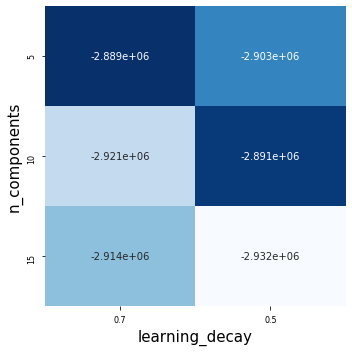

In [15]:
plt.figure(figsize=(5,5))
sns.heatmap(
    data, cmap='Blues', annot=True, fmt='.4', cbar=False,
    xticklabels=PARAM_GRID['latda__learning_decay'],
    yticklabels=PARAM_GRID['latda__n_components']
)
plt.xlabel('learning_decay', fontsize=15)
plt.ylabel('n_components', fontsize=15)
plt.tight_layout()

### **Ejercicio 4 : Inferencia e Identificación de Tópicos**

In [16]:
lda_model = LatentDirichletAllocation(
    n_components=grid_search.best_params_['latda__n_components'],
    learning_decay=grid_search.best_params_['latda__learning_decay'],
    max_iter=10, random_state=42, batch_size=128, evaluate_every=-1, n_jobs=-1
)

In [17]:
cvect = CountVectorizer(stop_words='english')
lda_model_fit = lda_model.fit(cvect.fit_transform(df['lyrics']))

In [18]:
for topic_id, topic_name in enumerate(lda_model_fit.components_):
    print('topic: {}'.format(topic_id+1))
    print(' '.join([cvect.get_feature_names()[i] for i in topic_name.argsort()[:-15-1:-1]]))

topic: 1
like got shit don know yo ain nigga man em fuck cause just yeah niggas
topic: 2
la ah da doo song mi future ba boom yeah eh lyrics page que moment
topic: 3
love don know oh just yeah baby ll let got like time want come ve
topic: 4
just like got don man ain ll cause know said say na ha make people
topic: 5
god death life blood die dead world eyes soul kill hell black pain war end


**(R)** ¿A qué tópicos están asociados cada clase inferida?

- `topic 1`: black music
- `topic 2`: classic rock
- `topic 3`: pop
- `topic 4`: soft rock
- `topic 5`: metal

### **Ejercicio 5: Identificación de probabilidades**

In [19]:
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = lda_model_fit.transform(cvect.fit_transform(df['lyrics']))
# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3), index=df.index)
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, lda_model_fit.n_components+1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis = 1) + 1

In [20]:
concatenated_df.sample(100)

,artist,genre,song,lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
5540,Slayer,metal,Witching Hour,"Come hear the moon is calling, \n The witching...",0.002,0.002,0.002,0.002,0.991,5
5620,Kiss,rock,Magic Touch,She's got the magic touch \n And you're walkin...,0.002,0.002,0.994,0.002,0.002,3
7702,Eminem,hiphop,Fly Away,"(Just Blaze - Chorus) \n Some people ask me, w...",0.493,0.001,0.318,0.189,0.001,1
2310,Weezer,rock,The Prettiest Girl In The Whole Wide World,Fall leaves falling \n Colder than air \n Too ...,0.002,0.002,0.990,0.002,0.002,3
4629,Anthrax,metal,Crush,(Now you see me now you dontx3) \n Now you see...,0.003,0.003,0.321,0.003,0.671,5
...,...,...,...,...,...,...,...,...,...,...
2567,Pink Floyd,rock,San Tropez,As I reach for a peach \n Slide a line down be...,0.104,0.002,0.684,0.208,0.002,3
7471,Eminem,hiphop,Soldier,I'm a soldier \n I'm a soldier \n Da da da da ...,0.562,0.001,0.092,0.001,0.344,1
4531,Meshuggah,metal,Demiurge,Writhing and embraced \n Retribution. Soul ecl...,0.100,0.005,0.069,0.005,0.821,5
10206,Immortal,metal,One By One,Aeons ago the legends tell we rode onward. \n ...,0.001,0.001,0.180,0.001,0.816,5


**(R)** Matriz de correlaciones:

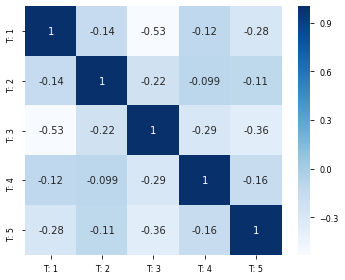

In [21]:
topics = concatenated_df.iloc[:,4:9]
corr = topics.corr()
f, ax = plt.subplots(figsize=(5,4))
sns.heatmap(corr, cmap='Blues', annot=True)
plt.tight_layout()

**(R)** La mayor correlación la encuentro entre los tópicos T1 y T3, sin correlaciones significativas entre los demás tópicos.

In [22]:
def report_artist_topic(infered_df, artist, plot_means = True, topic_label=None):
    """TODO: Docstring for report_artist_topic.

    :infered_df: TODO
    :artist: TODO
    :plot_means: TODO
    :returns: TODO

    """
    # en base al objeto retornado con identify_most_likely_topic, subseteamos por artista
    tmp_artist_topics = infered_df.query(f"artist == '{artist}'")
    # extraemos solo las columnas identificadas como topico
    topic_labels = [i if i.startswith('T') else None for i in tmp_artist_topics]
    # eliminamos las que no sean tópicos
    topic_labels = list(set(topic_labels).difference(set([None])))
    # subseteamos columnas
    tmp_artist_topics = tmp_artist_topics.loc[:, topic_labels]
    # calculamos la media a nivel de columna
    tmp_artist_means = tmp_artist_topics.apply(np.mean, axis=0)

    if topic_label is not None:
        tmp_artist_topics.columns=topic_label

    for index, (colname, serie) in enumerate(tmp_artist_topics.iteritems()):
        plt.subplot(len(topic_labels), 1, index + 1)
        sns.distplot(serie)
        sns.despine()
        if plot_means is True:
            plt.axvline(tmp_artist_means[index])

        plt.title(colname)
        plt.xlim(0, 1)
        plt.xlabel('')
        plt.tight_layout()

    return tmp_artist_means

**(R)** Probabilidades de pertenencia y gráfico correspondiente para un artista específico:

T: 1    0.005525
T: 3    0.369747
T: 4    0.036455
T: 5    0.569606
T: 2    0.018717
dtype: float64

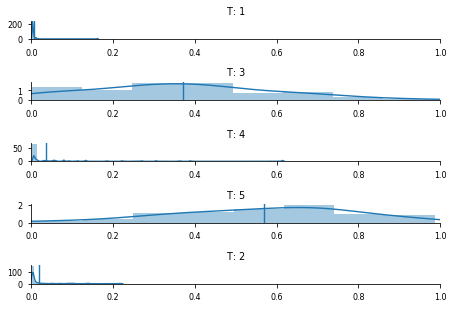

In [23]:
report_artist_topic(infered_df=concatenated_df, artist='Opeth')

**(R)** La mayor probabilidad para _Opeth_ es tópico T5, al que yo le asigné previamente _Metal_ (lo cual da razonablemente bueno).